In [ ]:
import pandas as pd
import numpy as np

def read_uci_har_data(features_path, labels_path):

    df_features = pd.read_csv(features_path, delim_whitespace=True, header=None)


    df_labels = pd.read_csv(labels_path, header=None, delim_whitespace=True, names=['activity'])

    df = pd.concat([df_features, df_labels], axis=1)

    return df

features_train_path = '/content/drive/MyDrive/human+activity+recognition+using+smartphones (1)/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt'
labels_train_path = '/content/drive/MyDrive/human+activity+recognition+using+smartphones (1)/UCI HAR Dataset/UCI HAR Dataset/activity_labels.txt'


df_train = read_uci_har_data(features_train_path, labels_train_path)


print(df_train.head(10))


<ipython-input-11-f897fd74f84d>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_features = pd.read_csv(features_path, delim_whitespace=True, header=None)
<ipython-input-11-f897fd74f84d>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_labels = pd.read_csv(labels_path, header=None, delim_whitespace=True, names=['activity'])


          0         1         2         3         4         5         6  \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   
5  0.277199 -0.010098 -0.105137 -0.997335 -0.990487 -0.995420 -0.997627   
6  0.279454 -0.019641 -0.110022 -0.996921 -0.967186 -0.983118 -0.997003   
7  0.277432 -0.030488 -0.125360 -0.996559 -0.966728 -0.981585 -0.996485   
8  0.277293 -0.021751 -0.120751 -0.997328 -0.961245 -0.983672 -0.997596   
9  0.280586 -0.009960 -0.106065 -0.994803 -0.972758 -0.986244 -0.995405   

          7         8         9  ...       552       553       554       555  \
0 -0.983185 -0.923527 -0.934724  ... -0.298676 -0.710304 -0.112754  0.030400   
1 -0.974914 -0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

np.random.seed(0)

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:

!pip install -U -q PyDrive


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [ ]:

dataset_file_id = '1xnD6OXIMNOChR4V9DKO-Jjsb7QNMUjc0'


In [ ]:

downloaded = drive.CreateFile({'id':dataset_file_id})
downloaded.GetContentFile('UCI HAR Dataset.zip')


In [ ]:
!unzip "/content/UCI HAR Dataset.zip" -d "/content/"

Archive:  /content/UCI HAR Dataset.zip
replace /content/UCI HAR Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/UCI HAR Dataset/.DS_Store  
replace /content/__MACOSX/UCI HAR Dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/__MACOSX/UCI HAR Dataset/._.DS_Store  
replace /content/UCI HAR Dataset/activity_labels.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/UCI HAR Dataset/activity_labels.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: /content/UCI HAR Dataset/features.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._features.txt  
  inflating: /content/UCI HAR Dataset/features_info.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: /content/UCI HAR Dataset/README.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._README.txt  
  inflating: /content/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
  inf

In [ ]:
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values


def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)

	loaded = dstack(loaded)
	return loaded


def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'

	filenames = list()

	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']

	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']

	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

	X = load_group(filenames, filepath)

	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

def load_dataset(prefix=''):

    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')

    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    trainy = trainy - 1
    testy = testy - 1

    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy



In [ ]:


trainX, trainy, testX, testy = load_dataset()

<ipython-input-20-3ee7d156ee38>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-20-3ee7d156ee38>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-20-3ee7d156ee38>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-20-3ee7d156ee38>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-2

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


<ipython-input-20-3ee7d156ee38>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)
<ipython-input-20-3ee7d156ee38>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = read_csv(filepath, header=None, delim_whitespace=True)


In [ ]:
import pandas as pd
import numpy as np

activity_names = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}


activity_labels = np.argmax(trainy, axis=1) + 1


activity_counts = pd.Series(activity_labels).map(activity_names).value_counts()

print("Activity Counts:\n", activity_counts)

total_samples = len(activity_labels)
print("\nTotal Number of Samples:", total_samples)

Activity Counts:
 LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

Total Number of Samples: 7352


<Axes: title={'center': 'Activity Counts classification in trining '}>

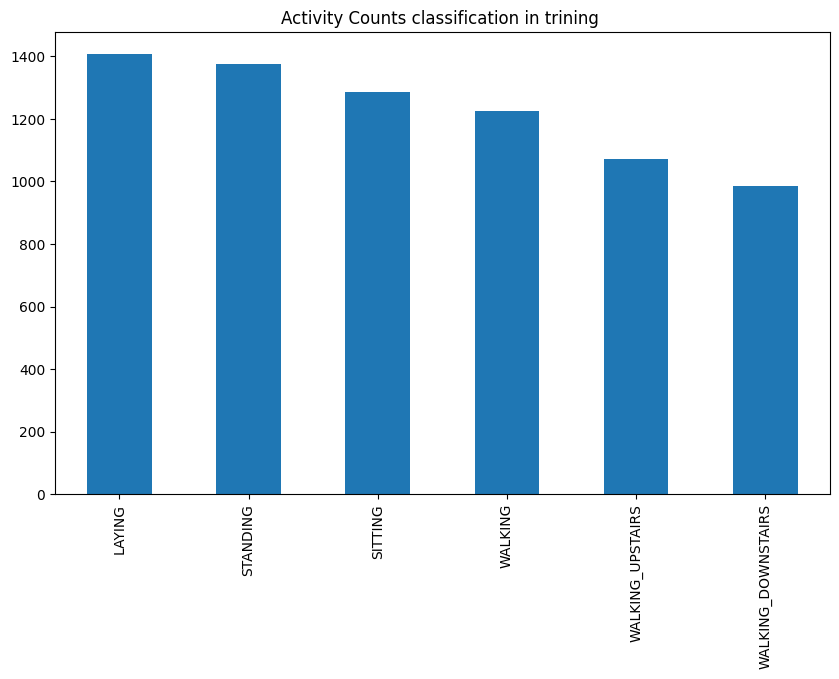

In [ ]:
activity_counts.plot(kind='bar', title='Activity Counts classification in trining ', figsize=(10, 6))


NUMBER OF SAMPLES BELONGING TO EACH VOLUNTER

In [ ]:
import pandas as pd
import numpy as np

activity_names = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING"
}


activity_labels = np.argmax(trainy, axis=1)


num_subjects = 30

samples_per_subject = len(trainX) // num_subjects

subject_ids = np.repeat(np.arange(1, num_subjects + 1), samples_per_subject)

subject_ids = np.concatenate([subject_ids, np.repeat(num_subjects, len(activity_labels) - len(subject_ids))])

df = pd.DataFrame({'subject_id': subject_ids, 'activity': activity_labels})

activity_counts_by_subject = df.groupby('subject_id')['activity'].apply(lambda x: x.map(activity_names).value_counts())


print("Activity Counts by Subject:\n", activity_counts_by_subject)

total_counts_per_subject = activity_counts_by_subject.groupby('subject_id').sum()

expected_counts = len(trainX) // num_subjects
print("\nTotal Counts per Subject:\n", total_counts_per_subject)
print("\nExpected Counts per Subject:", expected_counts)


tolerance = 5
mismatches = total_counts_per_subject[abs(total_counts_per_subject - expected_counts) > tolerance]
if len(mismatches) > 0:
    print("\nWarning: Total counts for some subjects deviate significantly from expected counts:")
    print(mismatches)
else:
    print("\nCross-verification successful: Total counts per subject are consistent with expected counts.")

Activity Counts by Subject:
 subject_id                    
1           STANDING              53
            SITTING               47
            LAYING                47
            WALKING               47
            WALKING_UPSTAIRS      26
                                  ..
30          WALKING_DOWNSTAIRS    56
            STANDING              32
            LAYING                32
            WALKING               32
            SITTING               30
Name: activity, Length: 180, dtype: int64

Total Counts per Subject:
 subject_id
1     245
2     245
3     245
4     245
5     245
6     245
7     245
8     245
9     245
10    245
11    245
12    245
13    245
14    245
15    245
16    245
17    245
18    245
19    245
20    245
21    245
22    245
23    245
24    245
25    245
26    245
27    245
28    245
29    245
30    247
Name: activity, dtype: int64

Expected Counts per Subject: 245

Cross-verification successful: Total counts per subject are consistent with expected cou

In [ ]:
!pip install matplotlib seaborn

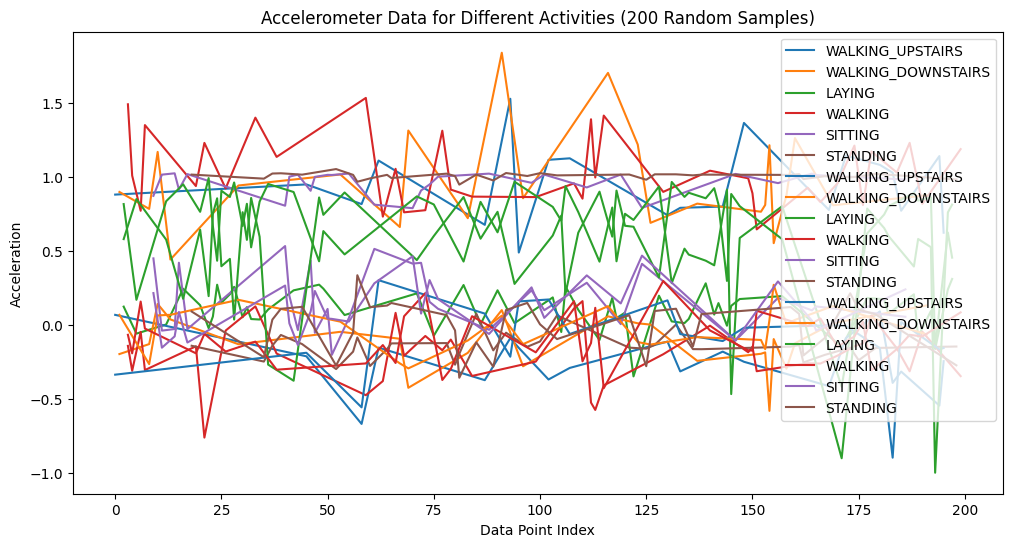

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


random_indices = random.sample(range(len(trainX)), 200)
selected_X = trainX[random_indices]
selected_y = trainy[random_indices]

activity_labels = np.argmax(selected_y, axis=1)

selected_X_2d = selected_X[:, 0, :3]


df = pd.DataFrame(selected_X_2d, columns=['x', 'y', 'z'])
df['activity'] = activity_labels
df['activity_name'] = df['activity'].map(activity_names)

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y='x', hue='activity_name', data=df)
sns.lineplot(x=df.index, y='y', hue='activity_name', data=df)
sns.lineplot(x=df.index, y='z', hue='activity_name', data=df)
plt.title('Accelerometer Data for Different Activities (200 Random Samples)')
plt.xlabel('Data Point Index')
plt.ylabel('Acceleration')
plt.legend(loc='upper right')
plt.show()

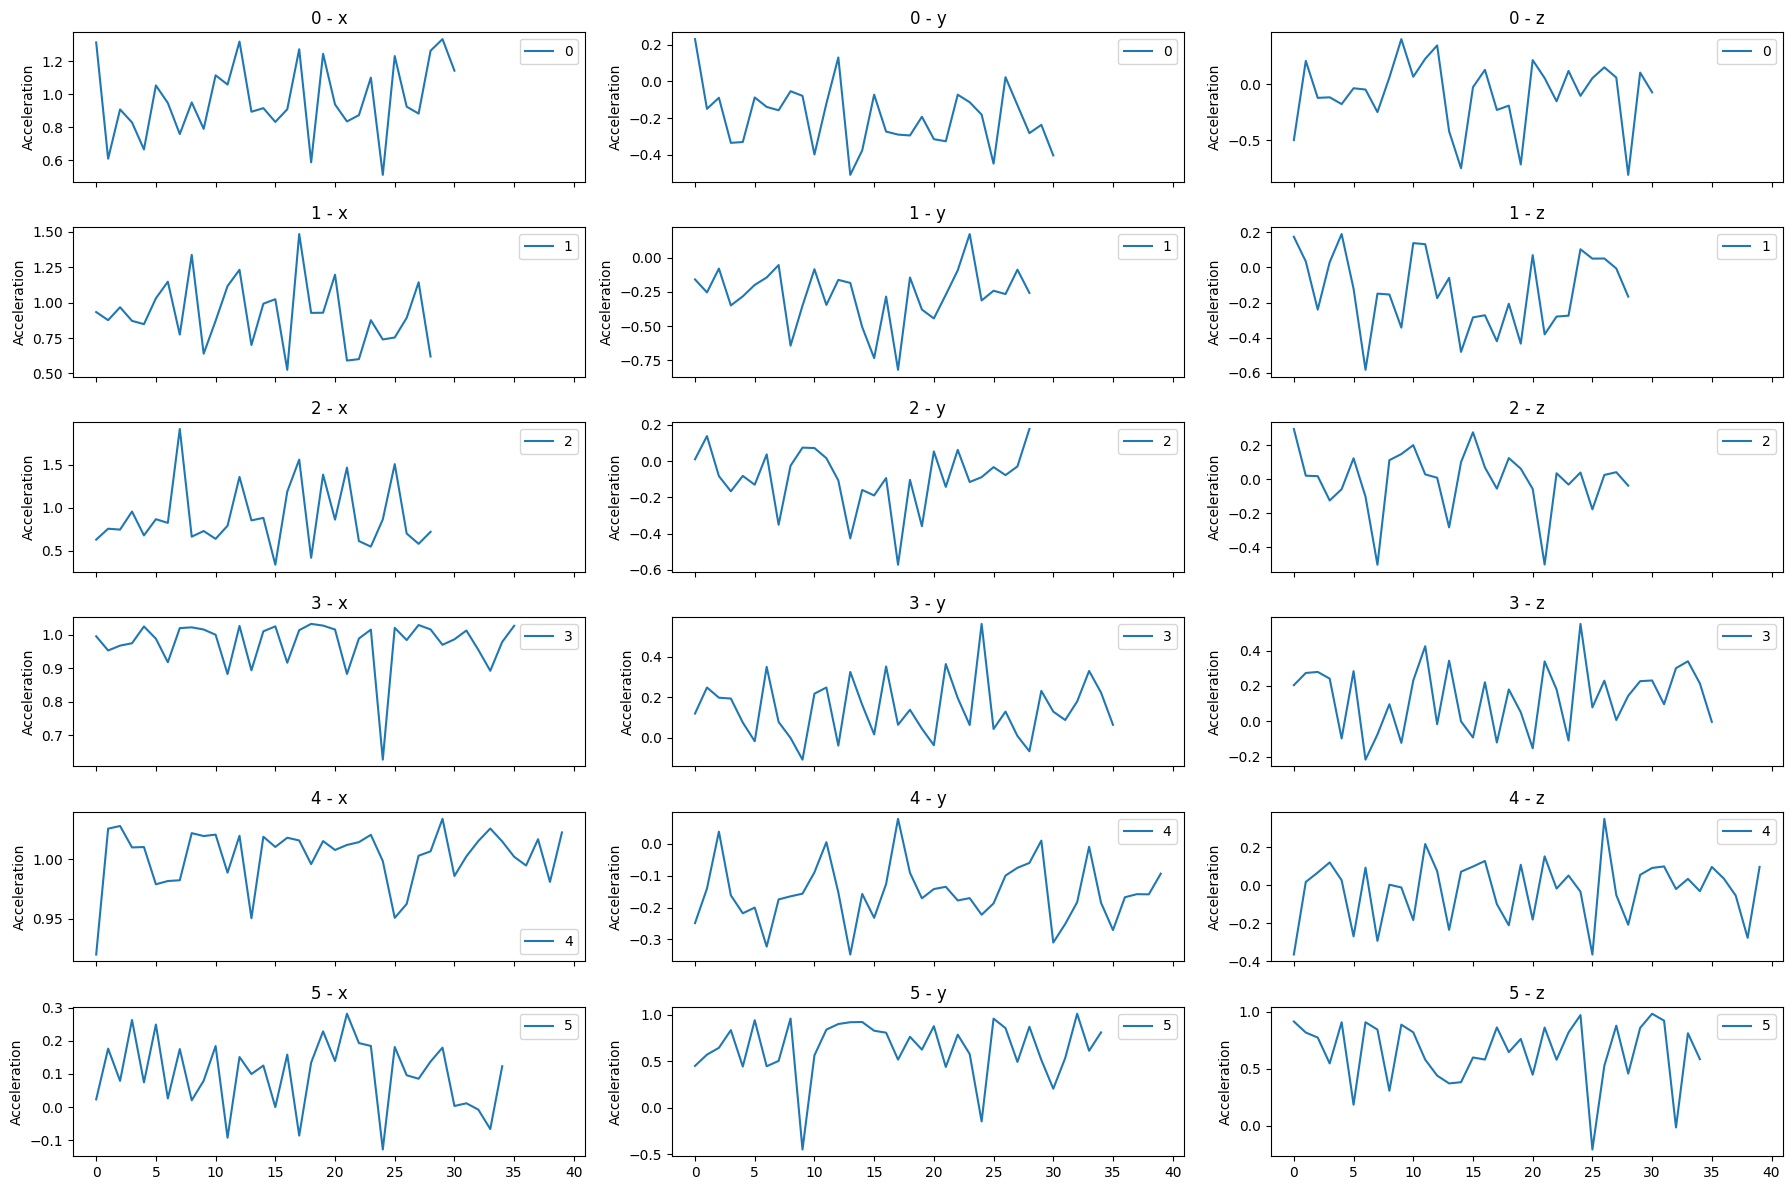

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

random_indices = random.sample(range(len(trainX)), 200)
selected_X = trainX[random_indices]
selected_y = trainy[random_indices]

activity_labels = np.argmax(selected_y, axis=1)


selected_X_2d = selected_X[:, 0, :3]



fig, axes = plt.subplots(6, 3, figsize=(18, 12), sharex=True)

for i, activity in enumerate(activity_names):
    for j, axis in enumerate(['x', 'y', 'z']):
        activity_indices = np.where(activity_labels == i)[0]


        activity_data_axis = selected_X_2d[activity_indices, j]

        if len(activity_data_axis) == 0:
            print(f"Skipping plot for {activity} - {axis} due to empty data.")
            continue

        sns.lineplot(x=range(len(activity_data_axis)), y=activity_data_axis, ax=axes[i, j])
        axes[i, j].set_title(f'{activity} - {axis}')
        axes[i, j].set_ylabel('Acceleration')

plt.tight_layout()
plt.show()